# Encoder Decoder

## Set up

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import time
import random
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from matplotlib import image as mpimg
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

PyTorch version: 2.1.0+cu121


In [2]:
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
else:
    device = torch.device("cpu")

In [3]:
WIDTH, HEIGHT = 28, 28
EPOCHS: int = 20
BATCH_SIZE: int = 32

In [4]:
resources_folder = 'resources/classification'

classes = ['apple', 'golf club', 'hedgehog', 'moon', 'mushroom', 'rain', 'roller coaster', 'squirrel']
nb_classes = len(classes)

data = [np.load(os.path.join(resources_folder, 'full_numpy_bitmap_'+class_name+'.npy')) for class_name in classes]
print(f'loaded numpy bitmaps, {nb_classes} classes')

print(len(data))
print(data[0].shape)
print(data[0][0].shape)

loaded numpy bitmaps, 8 classes
8
(144722, 784)
(784,)


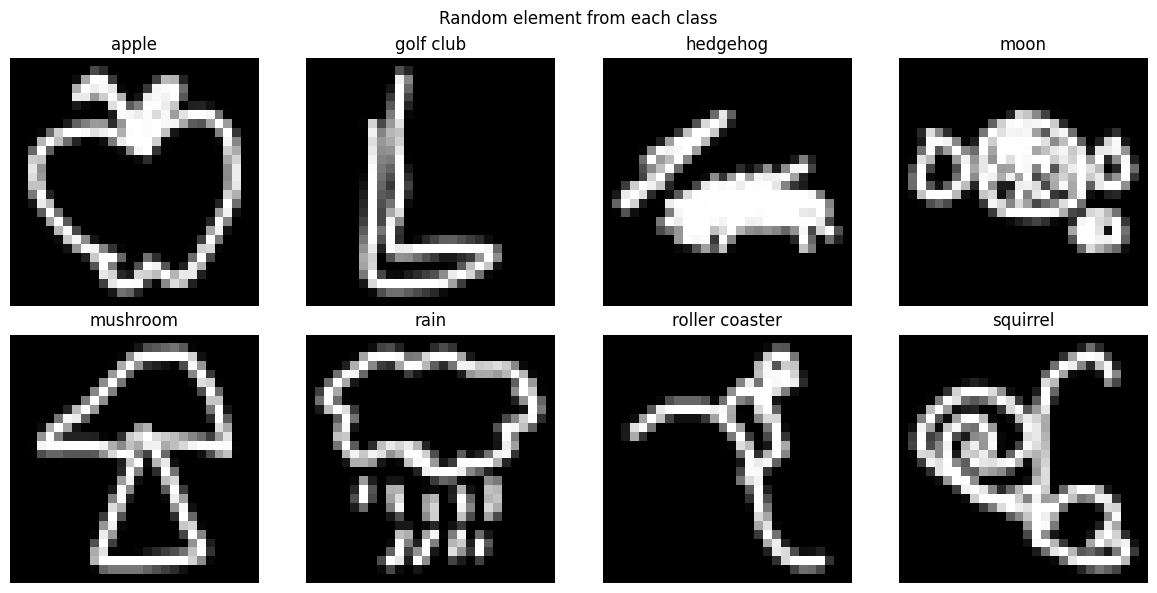

In [5]:
to_plot = []

for class_data in data:
    array = random.choice(class_data).reshape(WIDTH, HEIGHT)
    to_plot.append(array)

num_cols = 4
num_rows = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i in range(nb_classes):
    row_index = i // num_cols
    col_index = i % num_cols
    axes[row_index, col_index].imshow(to_plot[i], cmap='gray')
    axes[row_index, col_index].axis('off')
    axes[row_index, col_index].set_title(classes[i])

plt.tight_layout()
plt.suptitle('Random element from each class')

plt.subplots_adjust(top=0.9)

plt.show()

## Dataset creation

In [6]:
from dataset_creation.DataManager import DataManager

data_manager = DataManager()

split = 0.8
training_data, training_labels, validation_data, validation_labels = data_manager.split_data(split, data)

print(f'training dataset size : {len(training_data)}')
print(f'validation dataset size : {len(validation_data)}')

training dataset size : 927239
validation dataset size : 231814


In [7]:
shuffled_training_data, shuffled_training_labels = data_manager.shuffle_dataset(training_data, training_labels)

shuffled_validation_data, shuffled_validation_labels = data_manager.shuffle_dataset(validation_data, validation_labels)

In [8]:
from dataset_creation.GraysacleDataset import GrayscaleDataset

len_subset = 2000
valid_test_subset = 500

training_set = GrayscaleDataset(data=shuffled_training_data[:len_subset], labels=shuffled_training_labels[:len_subset],
                             width=WIDTH, height=HEIGHT, reshape=False, normalize=True)
validation_set = GrayscaleDataset(data=shuffled_validation_data[:valid_test_subset], labels=shuffled_validation_labels[:valid_test_subset],
                             width=WIDTH, height=HEIGHT, reshape=False, normalize=True)

training_loaded_set = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
validation_loaded_set = DataLoader(validation_set, batch_size=BATCH_SIZE , shuffle=True)

## Autoencoder class

In [9]:
from src.linear_autoencoder import LinearAutoencoder
from src.linear_autoencoder_embed import LinearAutoencoderEmbed

## Try with simple model

In [10]:
architecture_1 = [WIDTH * HEIGHT, WIDTH * HEIGHT // 2]
#autoencoder_model = LinearAutoencoder(architecture_1, device, WIDTH, HEIGHT, classes, dropout=0.1, batch_norm=True, encode_class=True)
autoencoder_model = LinearAutoencoderEmbed(architecture_1, device, WIDTH, HEIGHT, classes, dropout=0.3, batch_norm=True, class_number=len(classes))
autoencoder_model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=0.001)

In [11]:
# Print architecture 
autoencoder_model.print_model()

# Compression factor 
print(f'Compression factor: {WIDTH * HEIGHT / architecture_1[-1]}')

Sequential(
  (encoder_0): Linear(in_features=784, out_features=392, bias=True)
)
Sequential(
  (decoder_1): Linear(in_features=392, out_features=784, bias=True)
  (decoder_sigmoid): Sigmoid()
)
Compression factor: 2.0


In [12]:
num_epochs = 40
autoencoder_model.train_autoencoder(training_loaded_set, validation_loaded_set, criterion, optimizer, num_epochs)

Epoch [1/40]	Loss: 0.0815	Test Loss 0.0735	Train PSNR: 11.7955	Train SSIM: 0.1500	Validation PSNR: 11.7358	Validation SSIM: 0.1493
Epoch [2/40]	Loss: 0.0584	Test Loss 0.0555	Train PSNR: 13.1226	Train SSIM: 0.2103	Validation PSNR: 12.9847	Validation SSIM: 0.2047
Epoch [3/40]	Loss: 0.0381	Test Loss 0.0427	Train PSNR: 14.3095	Train SSIM: 0.2961	Validation PSNR: 14.0206	Validation SSIM: 0.2852
Epoch [4/40]	Loss: 0.0349	Test Loss 0.0380	Train PSNR: 15.3548	Train SSIM: 0.3570	Validation PSNR: 14.9180	Validation SSIM: 0.3411
Epoch [5/40]	Loss: 0.0324	Test Loss 0.0288	Train PSNR: 16.2850	Train SSIM: 0.4029	Validation PSNR: 15.7119	Validation SSIM: 0.3841
Epoch [6/40]	Loss: 0.0253	Test Loss 0.0224	Train PSNR: 17.1431	Train SSIM: 0.4447	Validation PSNR: 16.4031	Validation SSIM: 0.4233
Epoch [7/40]	Loss: 0.0154	Test Loss 0.0186	Train PSNR: 17.8933	Train SSIM: 0.4818	Validation PSNR: 17.0130	Validation SSIM: 0.4593
Epoch [8/40]	Loss: 0.0141	Test Loss 0.0180	Train PSNR: 18.5494	Train SSIM: 0.5003	V

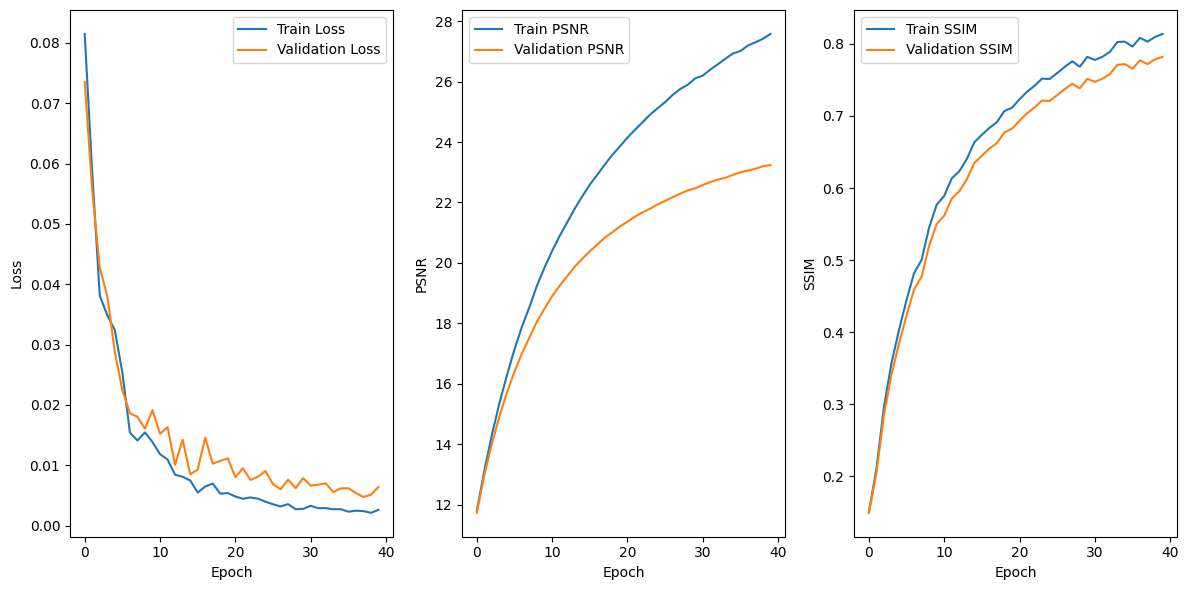

In [13]:
# plot Train and Test Loss, PSNR and SSIM values
autoencoder_model.plot_psnr_ssim()

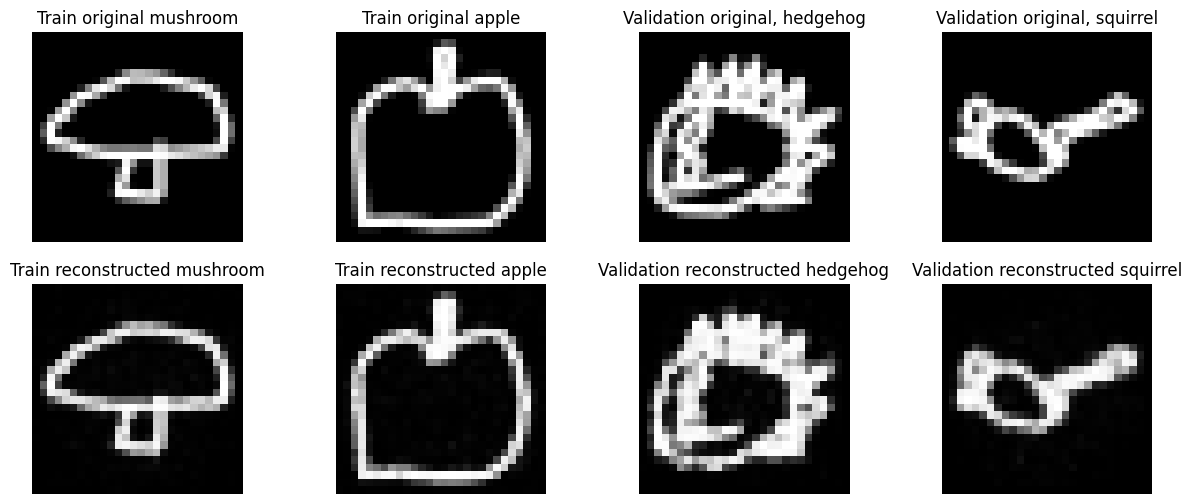

In [14]:
# plot some original and reconstructed images
autoencoder_model.show_images(training_set, validation_set)

In [15]:
CHECK_BACTH_SIZE = 8000

training_check_dataloader= DataLoader(training_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)
validation_check_dataloader = DataLoader(validation_set, batch_size=CHECK_BACTH_SIZE, shuffle=False)

In [16]:
# Show the lowest psnr then ssim in the test set
lowest_psnr, lowest_ssim = autoencoder_model.return_lowest_image_index_psnr_ssim(validation_check_dataloader)
print(f'Lowest PSNR index: {lowest_psnr[0]} | {lowest_psnr[1]}, Lowest SSIM index: {lowest_ssim[0]} | {lowest_ssim[1]}')

Lowest PSNR index: 387 | 15.973325462272832, Lowest SSIM index: 437 | 0.5202699118954606


[387, 15.973325462272832]
[437, 0.5202699118954606]


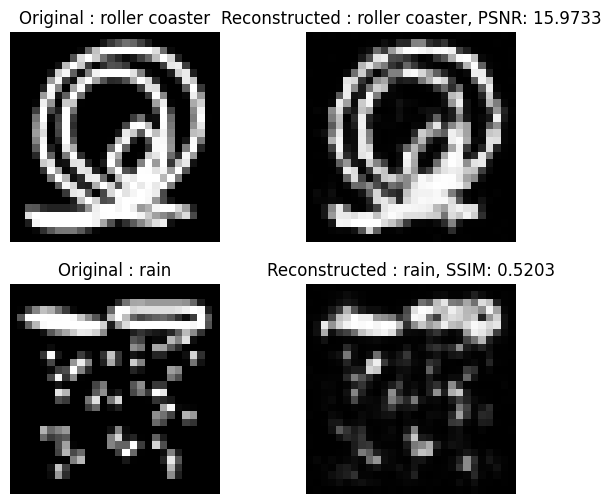

In [17]:
# Show image with the lowest psnr and ssim compared to their original the test set on same plot
print(lowest_psnr)
print(lowest_ssim)
autoencoder_model.show_lowest_psnr_ssim_image(validation_set, lowest_psnr, lowest_ssim)

## Generating images

In [23]:
def return_classes_mean_encoded_vector(model, images_set):
    mean_encoded_vectors = []
    mean_vectors_size = model.architecture[-1]
    count_classes_number = [0] * nb_classes

    for i in range(nb_classes):
        mean_encoded_vectors.append(np.zeros(mean_vectors_size))

    for batch in images_set:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        encoded, decoded = model(images, labels=labels)
        encoded_np = encoded.cpu().detach().numpy()

        for i in range(len(images)):
            mean_encoded_vectors[labels[i]] += encoded_np[i]
            count_classes_number[labels[i]] += 1
            
    for i in range(nb_classes):
        mean_encoded_vectors[i] = mean_encoded_vectors[i] / count_classes_number[i]

        print(f'Class {classes[i]} range of mean encoded vector: [{mean_encoded_vectors[i].min()}, {mean_encoded_vectors[i].max()}]')

    return mean_encoded_vectors

def generated_images_for_mean_vector(mean_encoded_vectors, model):
    generated_images = []

    decoder = model.decoder
    for i in range(nb_classes):
        mean_vector = mean_encoded_vectors[i]
        double_mean_vector = np.array([mean_vector]).astype(np.float32)
        mean_vector_torch = torch.from_numpy(double_mean_vector).to(device)

        decoded = decoder(mean_vector_torch)

        generated_images.append(decoded.cpu().detach().numpy()[0].reshape(HEIGHT, WIDTH))

    return generated_images

def show_generated_images(generated_images):
    num_cols = 4
    num_rows = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

    for i in range(nb_classes):
        row_index = i // num_cols
        col_index = i % num_cols
        axes[row_index, col_index].imshow(generated_images[i], cmap='gray')
        axes[row_index, col_index].axis('off')
        axes[row_index, col_index].set_title(classes[i])

    plt.tight_layout()
    plt.suptitle('Generated images')

    plt.subplots_adjust(top=0.9)

    plt.show()

In [24]:
def create_alternative_version(mean_vector, weight=0.1):
    alternative_mean_vector = mean_vector.copy()
    # Vector is composed of float values 
    # use gaussian distribution to generate altertivate vector based on mean one

    for i in range(len(mean_vector)):
        alternative_mean_vector[i] = np.random.normal(mean_vector[i], weight)
    
    return alternative_mean_vector

Class apple range of mean encoded vector: [-3.0524133272792984, 4.324171845550122]
Class golf club range of mean encoded vector: [-2.966070743656424, 2.686831451558137]
Class hedgehog range of mean encoded vector: [-3.269744268581692, 3.2345565631564726]
Class moon range of mean encoded vector: [-3.3723373418480023, 3.3717236022603996]
Class mushroom range of mean encoded vector: [-3.6761997620571534, 3.079162422294322]
Class rain range of mean encoded vector: [-3.3735781776623464, 3.3063345485784876]
Class roller coaster range of mean encoded vector: [-3.133508368900844, 3.5665841477257865]
Class squirrel range of mean encoded vector: [-3.14544491814632, 3.231792643958447]


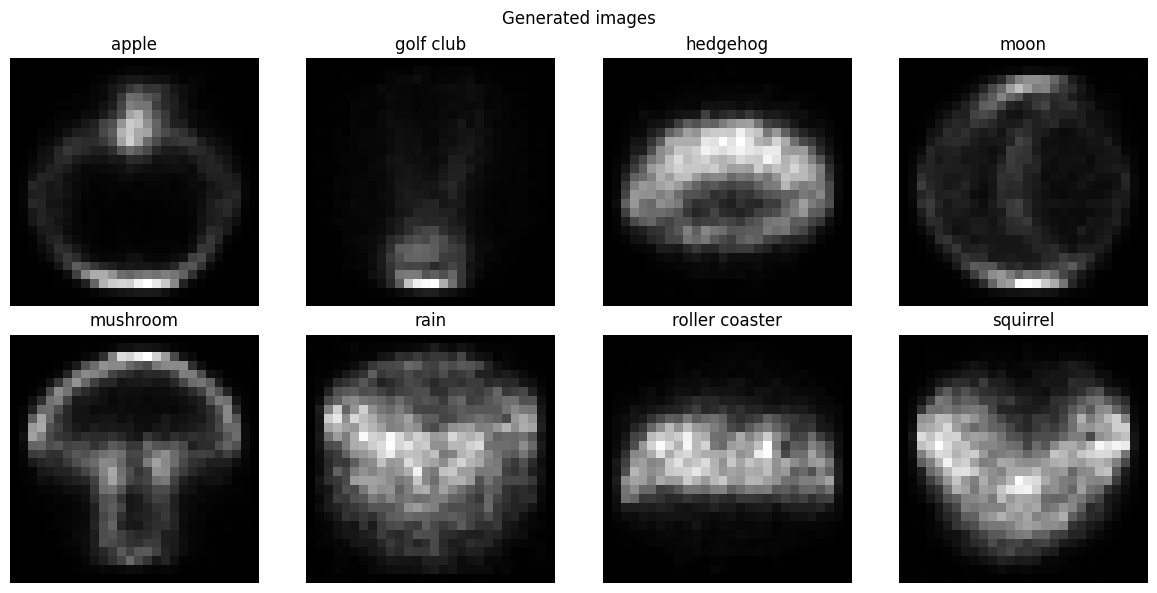

In [25]:
mean_encoded_vectors = return_classes_mean_encoded_vector(autoencoder_model, training_loaded_set)
generated_images = generated_images_for_mean_vector(mean_encoded_vectors, autoencoder_model)
show_generated_images(generated_images)

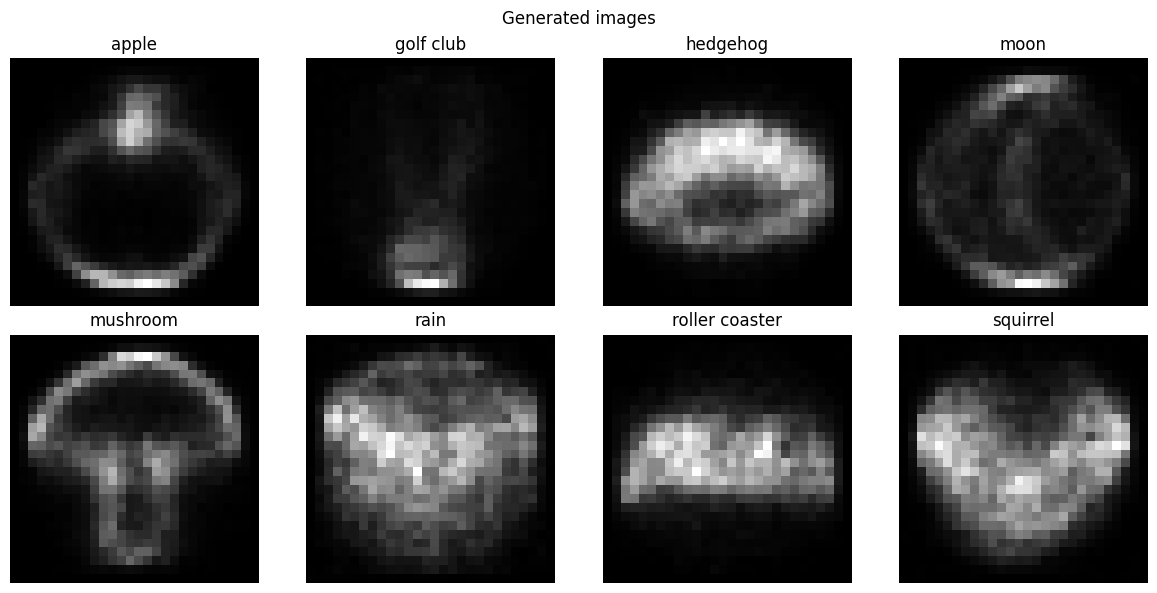

In [26]:
alternative_versions = []
for mean_encoded_vector in mean_encoded_vectors:
    alternative_versions.append(create_alternative_version(mean_encoded_vector, 0.05))

alternative_generated_version = generated_images_for_mean_vector(alternative_versions, autoencoder_model)
show_generated_images(alternative_generated_version)